# Imports

In [1]:
import pandas as pd
import numpy as np

# import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

# from numpy.random import normal, uniform
# import random

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold, train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.neural_network import MLPRegressor

import dill
import datetime

In [2]:
%matplotlib inline

In [3]:
# dill.dump_session('Full_NN.db')

In [4]:
# dill.load_session('Full_NN.db')

In [5]:
SEED = 73 # random seed

# Data reading 

In [6]:
data = pd.read_csv('data/prepared/data_processed.csv')

In [7]:
names = data.columns
names

Index(['AP1', 'FD', 'FTa1', 'FTa2', 'FTa3', 'FTb', 'FTc', 'LFY', 'TFL1a',
       'TFL1c'],
      dtype='object')

In [8]:
len(names)

10

In [9]:
gs = {} # dict of GS-tuned models

In [10]:
st_scalers = {}

In [11]:
def logging(description, out):
    string = str(description) + ': ' + str(out)
    with open('results/NN/NN_log.txt', 'a') as out_file:
        out_file.write(string + '\n')
    print(string)

In [ ]:
def clear_log():
    with open('results/NN/NN_log.txt', 'w') as out_file:
        out_file.write('log file have been cleared ' + str(datetime.datetime.now().strftime('%d-%m-%Y %H:%M:%S')))

In [49]:
clear_log()

In [50]:
clear_log()

In [13]:
logging('Running datetime', str(datetime.datetime.now().strftime('%d-%m-%Y %H:%M:%S')))

Running datetime: 28-08-2019 16:10:53


# Everything below should be in cycle !!!!

In [14]:
current_target = names[0]
current_target

'AP1'

In [ ]:
# for name in names:
#     current_target = name
    

In [15]:
logging('target', current_target)

target: AP1


In [16]:
# Choose target and standartize the data

y = data[current_target]
X = data.drop(current_target, axis=1)

In [17]:
st_scalers[current_target] = StandardScaler()

In [18]:
X_st = st_scalers[current_target].fit_transform(X)

In [19]:
# train-test split

X_st_train, X_st_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = 0.25, random_state=SEED, shuffle=True)

# NN model

## Model building

In [ ]:
# svm_reg = SVR(kernel='rbf', epsilon=1)

In [84]:
model = MLPRegressor(hidden_layer_sizes=(9, 4), solver='sgd', validation_fraction=0.25,
                     n_iter_no_change=50, max_iter=5000, early_stopping=True,
                     learning_rate='adaptive', alpha=0.00054, activation='logistic')



## Rough grid search

In [85]:
cv = KFold(n_splits=5, shuffle=True, random_state=SEED)

grid = {
    'hidden_layer_sizes': [(100,), (9, 4)],
    #'hidden_layer_sizes': hidden_layer_sizes,
    'alpha': np.geomspace(0.00001, 0.1, 5)#,
    #'activation' : ['logistic', 'relu']
    #'learning_rate_init': np.geomspace(0.001, 0.1, 3)
}

gs[current_target] = GridSearchCV(model, grid, 
                  n_jobs=-1, 
                  scoring=['neg_mean_squared_error', 'r2'], 
                  refit='neg_mean_squared_error', 
                  cv=cv, 
                  verbose=10)

In [94]:
def GridS(model, grid, **kwargs):
    return GridSearchCV(model, grid, 
                      n_jobs=-1, 
                      scoring=['neg_mean_squared_error', 'r2'], 
                      refit='neg_mean_squared_error', 
                      cv=cv, 
                      verbose=10)

In [85]:
cv = KFold(n_splits=5, shuffle=True, random_state=SEED)

grid = {
    'hidden_layer_sizes': [(100,), (9, 4)],
    #'hidden_layer_sizes': hidden_layer_sizes,
    'alpha': np.geomspace(0.00001, 0.1, 5)#,
    #'activation' : ['logistic', 'relu']
    #'learning_rate_init': np.geomspace(0.001, 0.1, 3)
}

In [95]:
gs[current_target] = GridS(model, grid)

In [96]:
%%time
gs[current_target].fit(X_st_train.values, y_train.values);

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    4.5s


KeyboardInterrupt: 

In [89]:
gs[current_target].best_params_

{'alpha': 0.01, 'hidden_layer_sizes': (100,)}

In [90]:
gs[current_target].best_score_

-59463.726768007815

In [30]:
HL_sizes, alpha = gs[current_target].best_params_['hidden_layer_sizes'], gs[current_target].best_params_['alpha']

In [91]:
pd.DataFrame(gs[current_target].cv_results_)[['param_hidden_layer_sizes',
                                            'mean_test_neg_mean_squared_error',
                                            'std_test_neg_mean_squared_error',
                                            'std_train_neg_mean_squared_error',
                                            'rank_test_neg_mean_squared_error']].T

C:\Users\Boris\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_neg_mean_squared_error'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\Boris\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split1_train_neg_mean_squared_error'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\Boris\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split2_train_neg_mean_squared_error'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\U

,0,1,2,3,4,5,6,7,8,9
param_hidden_layer_sizes,"(100,)","(9, 4)","(100,)","(9, 4)","(100,)","(9, 4)","(100,)","(9, 4)","(100,)","(9, 4)"
mean_test_neg_mean_squared_error,-62885.4,-67125.1,-61115.2,-74287.8,-61410.3,-70657.8,-59463.7,-72819.2,-61033.4,-74833.3
std_test_neg_mean_squared_error,20584.2,15691.4,19583.1,23417.8,16571.1,26925.8,14750.8,21782.5,17991.2,22149.3
std_train_neg_mean_squared_error,3724.89,9322.08,6667.42,5743.87,7345.02,6109.28,6794.58,5426.85,7934.83,4836.73
rank_test_neg_mean_squared_error,5,6,3,9,4,7,1,8,2,10


In [32]:
logging('Rough tuning', str(gs[current_target].best_params_))    

AttributeError: 'GridSearchCV' object has no attribute 'best_params_'

## Fine tuning

In [36]:
cv = KFold(n_splits=5, shuffle=True, random_state=SEED)

grid = {
    'hidden_layer_sizes': HL_sizes,
    #'hidden_layer_sizes': hidden_layer_sizes,
    'alpha': np.geomspace(alpha/5, alpha*5, 10)#,
    #'activation' : ['logistic', 'relu']
    #'learning_rate_init': np.geomspace(0.001, 0.1, 3)
}

gs[current_target] = GridSearchCV(model, grid, 
                  n_jobs=-1, 
                  scoring=['neg_mean_squared_error', 'r2'], 
                  refit='neg_mean_squared_error', 
                  cv=cv, 
                  verbose=10)

In [37]:
%%time
gs[current_target].fit(X_st_train, y_train);

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   15.6s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   25.6s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   34.6s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   51.7s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  1.8min finished


Wall time: 1min 52s


GridSearchCV(cv=KFold(n_splits=5, random_state=73, shuffle=True),
       error_score='raise-deprecating',
       estimator=MLPRegressor(activation='logistic', alpha=1e-05, batch_size='auto',
       beta_1=0.9, beta_2=0.999, early_stopping=True, epsilon=1e-08,
       hidden_layer_sizes=(9, 4), learning_rate='adaptive',
       learning_rate_init=0.001, max_iter=5000, momentum=0.9,
       n_iter_no_change=50, nesterovs_momentum=True, power_t=0.5,
       random_state=None, shuffle=True, solver='sgd', tol=0.0001,
       validation_fraction=0.25, verbose=False, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'hidden_layer_sizes': (300,), 'alpha': array([0.02   , 0.0286 , 0.0409 , 0.05848, 0.08363, 0.11958, 0.171  ,
       0.24452, 0.34966, 0.5    ])},
       pre_dispatch='2*n_jobs', refit='neg_mean_squared_error',
       return_train_score='warn', scoring=['neg_mean_squared_error', 'r2'],
       verbose=10)

In [38]:
gs[current_target].best_params_

{'alpha': 0.17099759466766973, 'hidden_layer_sizes': 300}

In [39]:
gs[current_target].best_score_

-55456.54350537983

In [35]:
logging('Fine tuning', str(gs[current_target].best_params_))    

Fine tuning: {'alpha': 0.2, 'hidden_layer_sizes': 300}


In [40]:
model = gs[current_target].best_estimator_

## Test on train

In [80]:
# model.fit(X_st_train.values, y_train.values)

MLPRegressor(activation='logistic', alpha=0.00054, batch_size='auto',
       beta_1=0.9, beta_2=0.999, early_stopping=True, epsilon=1e-08,
       hidden_layer_sizes=(9, 4), learning_rate='adaptive',
       learning_rate_init=0.001, max_iter=5000, momentum=0.9,
       n_iter_no_change=50, nesterovs_momentum=True, power_t=0.5,
       random_state=None, shuffle=True, solver='sgd', tol=0.0001,
       validation_fraction=0.25, verbose=False, warm_start=False)

In [81]:
train_pred = model.predict(X_st_train)

In [82]:
def comparsion_plot(true_values, predictions, data_type = 'test', current_target=current_target):
    plt.scatter(true_values, predictions)
    plt.plot([min(true_values), max(true_values)], [min(true_values), max(true_values)], 'r')
    plt.xlabel('True Values' + ' (' + current_target + ')')
    plt.ylabel('Predictions' + ' (' + current_target + ')')
    plt.axis('equal')
    plt.axis('square')
    plt.title('SVR. Predictions on ' + data_type)
    plt.savefig('results/NN/' + data_type + '_pred_NN_' + current_target + '.png', bbox_inches='tight', dpi=300)
    plt.show()

In [60]:
def print_metrics(true_val, predicted_val):
    logging('r', np.corrcoef(true_val, predicted_val)[0,1].round(3))
    logging('MSE', mean_squared_error(true_val, predicted_val).round(3))
    logging('R2', r2_score(true_val, predicted_val).round(3))

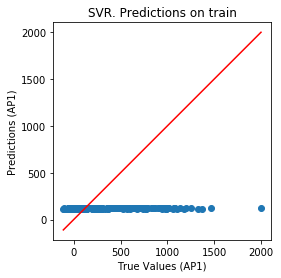

In [83]:
comparsion_plot(y_train, train_pred, data_type='train')

In [294]:
print_metrics(y_train, train_pred)

r: 0.585
MSE: 54686.367
R2: 0.272


## Test on test

In [62]:
predictions = model.predict(X_st_test)

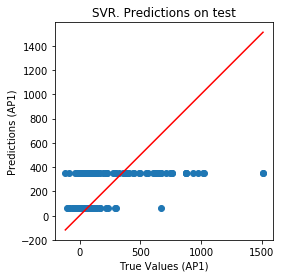

In [63]:
comparsion_plot(y_test, predictions, data_type='test')

In [ ]:
print_metrics(y_test, predictions)

NameError: name 'nms' is not defined

In [20]:
with open('NN_model.cached', 'wb') as file:
    dill.dump(gs, file)

In [21]:
with open('NN_scalers.cached', 'wb') as file:
    dill.dump(st_scalers, file)

In [ ]:
# dill.dump_session('Full_SVR.db')

In [ ]:
# !jupyter nbconvert --to script SVR_full_script.ipynb